In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pandas as pd
from astropy.io import fits
from scipy.signal import gaussian
from scipy.stats import norm

from IPython.display import display
from ipywidgets import interactive, FloatSlider, fixed
import ipywidgets as widgets
%matplotlib inline

In [2]:
psf = fits.open('../pixcmd/pcmdpy/pcmdpy/psf/ACS_WFC_F475W.fits')[0].data

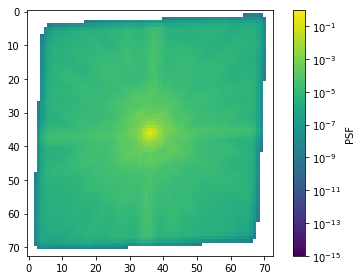

In [3]:
plt.imshow(psf, norm=mpl.colors.LogNorm(vmin=1e-15, vmax=1e0))
plt.colorbar(label='PSF')
plt.tight_layout()

In [4]:
import pcmdpy as ppy

GPU acceleration not available, sorry
No module named 'pycuda'


In [5]:
f = [ppy.instrument.ACS_WFC_F475W(1.0), ppy.instrument.ACS_WFC_F814W(1.0)]
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=False)

In [6]:
true_psfs = [f[0]._psf, f[1]._psf]

In [7]:
sig = 0.2
delta = 0.
psf0 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf0 /= psf0.sum()

sig = 0.4
delta = 0.
psf1 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf1 /= psf1.sum()

sig = 0.6
psf2 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf2 /= psf2.sum()

sig = 1.0
psf3 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf3 /= psf3.sum()

sig = 2.0
psf4 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf4 /= psf4.sum()

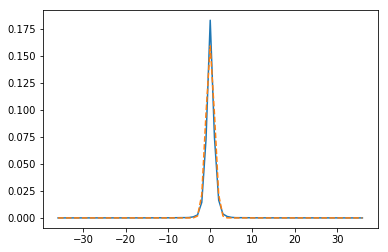

In [8]:
x = np.arange(-36, 37)
y = true_psfs[0][:,36]
# y /= y.sum()
plt.plot(x, y)
y2 = psf3[:, 36]
# y2 /= y2.sum()
plt.plot(x, y2, ls='--')
# plt.xlim([-10, 10])
# plt.yscale('log')   

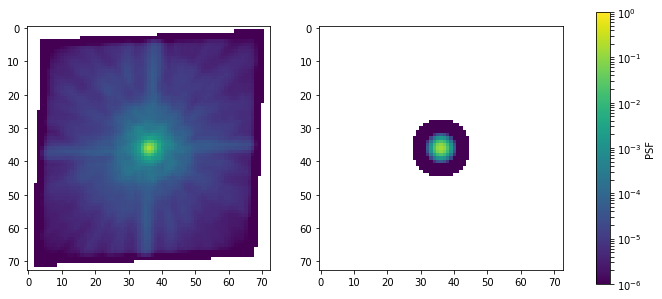

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
n = mpl.colors.LogNorm(vmin=1e-6, vmax=1)
plt.subplot(axes[0])
plt.imshow(f[0]._psf, norm=n)
plt.subplot(axes[1])
plt.imshow(psf3, norm=n)
plt.colorbar(label='PSF', ax=axes)
# plt.tight_layout()

In [10]:
def make_psf_pcmd(ims, sig=None):
    filters = driv.iso_model.filters
    if (sig is None):
        filters[0]._psf = true_psfs[0]
        filters[1]._psf = true_psfs[1]
    elif (sig <= 0.02):
        mags = np.array([f.counts_to_mag(im.flatten(), E_BV=g.dust) for f,im in zip(filters, ims)])
        pcmd = ppy.utils.make_pcmd(mags)
        return pcmd
    else:
        psf = np.outer(gaussian(73, sig), gaussian(73, sig))
        psf /= psf.sum()
        filters[0]._psf = filters[1]._psf = psf
    images = np.array([f.psf_convolve(im) for f,im in zip(filters, ims)])
    mags = np.array([f.counts_to_mag(im.flatten(), E_BV=g.dust) for f,im in zip(filters, images)])
    pcmd = ppy.utils.make_pcmd(mags)
    return pcmd

In [11]:
def plot_psf_pcmd(ims, sig, y_lim=[10., 0]):
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,6))
    n = mpl.colors.LogNorm()
    b=[np.linspace(1.0, 4.0, 100), np.linspace(y_lim[1], y_lim[0], 100)]

    plt.subplot(axes[0])
    pcmd_true = make_psf_pcmd(ims)
    _ = plt.hist2d(pcmd_true[0], pcmd_true[1], norm=n, bins=b)
    axes[0].set_title('True PSF')

    plt.subplot(axes[1])
    pcmd_1 = make_psf_pcmd(ims, sig)
    _ = plt.hist2d(pcmd_1[0], pcmd_1[1], norm=n, bins=b)
    axes[1].set_title('Gaussian PSF: {0:.2f} pix'.format(sig))
    for ax in axes:
        iso_model.plot_isochrone(g, ax=ax)
    axes[0].set_ylim([y_lim[0], y_lim[1]])
    axes[0].set_xlim([b[0][0], b[0][-1]])
    plt.subplots_adjust(wspace=0.06)
    plt.colorbar(ax=axes)
    plt.show()

In [12]:
g = ppy.galaxy.SSPModel(np.array([0., -2., 0., 10.0]))

N_im = 256

mags, ims_0 = driv.simulate(g, N_im, psf=False)

In [13]:
# sig_widget = widgets.Play(value=0.2, min=0.2, max=2.0, step=0.1, interval=10, disabled=False)
sig_widget = FloatSlider(min=0.0, max=2.0, step=0.05, continuous_update=False, description='PSF (pix)')
interactive_plot = interactive(plot_psf_pcmd, ims=fixed(ims_0), y_lim=fixed([10., 0.]), sig=sig_widget)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='PSF (pix)', max=2.0, step=0.05), Output()), _dom_classes=('widget-interact',))

In [14]:
g = ppy.galaxy.SSPModel(np.array([0., -2., 2., 10.0]))

N_im = 256

mags, ims_2 = driv.simulate(g, N_im, psf=False)

In [15]:
# sig_widget = widgets.Play(value=0.2, min=0.2, max=2.0, step=0.1, interval=10, disabled=False)
sig_widget = FloatSlider(min=0.0, max=2.0, step=0.05, continuous_update=False, description='PSF (pix)')
interactive_plot = interactive(plot_psf_pcmd, ims=fixed(ims_2), y_lim=fixed([2.5, -2.]), sig=sig_widget)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='PSF (pix)', max=2.0, step=0.05), Output()), _dom_classes=('widget-interact',))

In [16]:
def bin_image(im, factor):
    im1 = im.reshape(im.shape[0]//factor, factor, im.shape[1]//factor, factor)
    im2 = im1.sum(axis=-1).sum(axis=-2)
    return im2

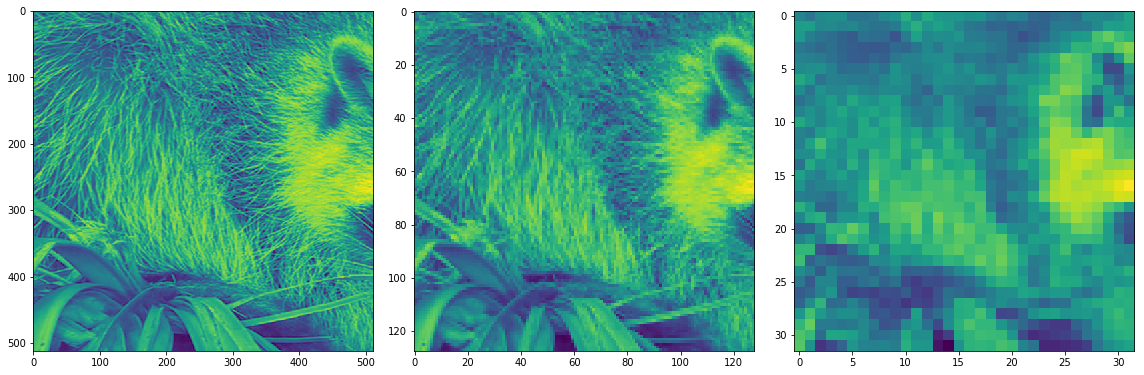

In [17]:
from scipy import misc
face = misc.face()[:512, :512, 0]
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
axes[0].imshow(bin_image(face, 1))
axes[1].imshow(bin_image(face, 4))
axes[2].imshow(bin_image(face, 16))
plt.tight_layout()

In [57]:
N_im_base = 256
sig = 1.0
pcmds = {}

In [ ]:
%%time
# regular
for factor in [1,2,4]:
    print(factor)
    N_im = 512*factor
    g = ppy.galaxy.SSPModel(np.array([0., -2., 2. - 2*np.log10(factor), 10.0]))
    mags, ims = driv.simulate(g, N_im, psf=False)

    psf = np.outer(gaussian(73*factor, sig*factor), gaussian(73*factor, sig*factor))
    psf /= psf.sum()
    filters = driv.iso_model.filters
    filters[0]._psf = filters[1]._psf = psf
    images = np.array([f.psf_convolve(im) for f,im in zip(filters, ims)])
    # bin by factor
    images = np.array([bin_image(im, factor) for im in images])
#     images = images[:, :256, :256]
    mags = np.array([f.counts_to_mag(im.flatten(), E_BV=g.dust) for f,im in zip(filters, images)])
    pcmds[factor] = ppy.utils.make_pcmd(mags)

In [ ]:
# with tiled true psf
print('Charlie\'s version')
N_im = 512
g = ppy.galaxy.SSPModel(np.array([0., -2., 2., 10.0]))
filters = driv.iso_model.filters
filters[0]._psf = make_tile(true_psfs[0], norm=True, shifts=[0., 0.25, 0.5, 0.75])
filters[1]._psf = make_tile(true_psfs[1], norm=True, shifts=[0., 0.25, 0.5, 0.75])
mags, ims = driv.simulate(g, N_im, psf=True)
pcmds['tiled_charlie'] = ppy.utils.make_pcmd(mags)

# with tiled true psf
print('My version')
N_im = 512
g = ppy.galaxy.SSPModel(np.array([0., -2., 2., 10.0]))
filters = driv.iso_model.filters
filters[0]._psf = make_tile(true_psfs[0], norm=True)
filters[1]._psf = make_tile(true_psfs[1], norm=True)
mags, ims = driv.simulate(g, N_im, psf=True)
pcmds['tiled_me'] = ppy.utils.make_pcmd(mags)

1
2
4


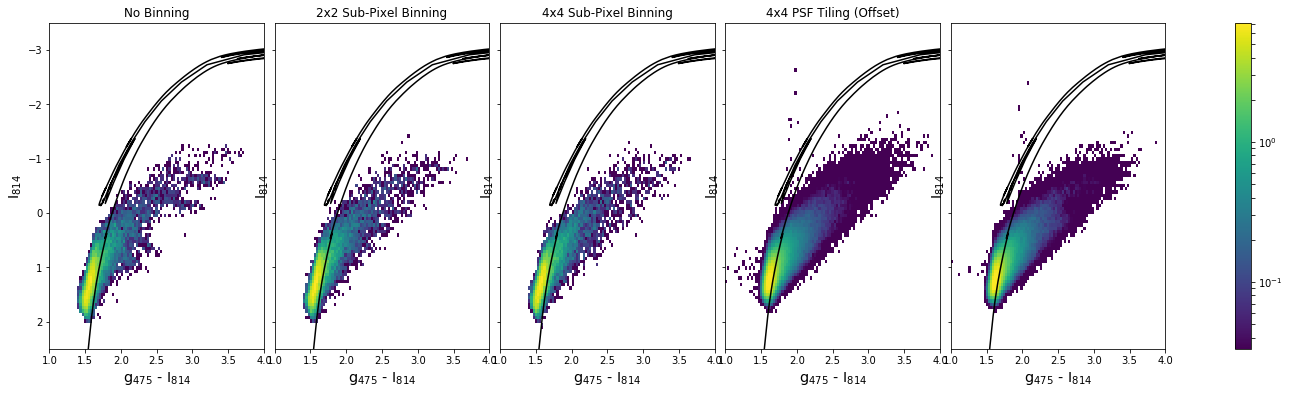

In [61]:
fig, axes = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(25, 6))
n = mpl.colors.LogNorm()
b=[np.linspace(1.0, 4.0, 100), np.linspace(-3.5, 2.5, 100)]

plt.subplot(axes[0])
_ = plt.hist2d(pcmds[1][0], pcmds[1][1], norm=n, bins=b, normed=True)
axes[0].set_title('No Binning')

plt.subplot(axes[1])
_ = plt.hist2d(pcmds[2][0], pcmds[2][1], norm=n, bins=b, normed=True)
axes[1].set_title('2x2 Sub-Pixel Binning')

plt.subplot(axes[2])
_ = plt.hist2d(pcmds[4][0], pcmds[4][1], norm=n, bins=b, normed=True)
axes[2].set_title('4x4 Sub-Pixel Binning')

plt.subplot(axes[3])
_ = plt.hist2d(pcmds['tiled_charlie'][0], pcmds['tiled_charlie'][1], norm=n, bins=b, normed=True)
axes[3].set_title('4x4 PSF Tiling (Offset)')

plt.subplot(axes[4])
_ = plt.hist2d(pcmds['tiled_me'][0], pcmds['tiled_me'][1], norm=n, bins=b, normed=True)
axes[4].set_title('4x4 PSF Tiling (Symmetric)')

for ax in axes:
    iso_model.plot_isochrone(g, ax=ax)
axes[0].set_ylim([b[1][-1], b[1][0]])
plt.subplots_adjust(wspace=0.05)
plt.colorbar(ax=axes)
plt.savefig('figures/subpixel_binning.pdf')

In [42]:
append = '../pixcmd/pcmdpy/pcmdpy/psf/f475w_'
psf_c = np.zeros((4, 4, 73, 73))
for i in range(4):
    for j in range(4):
        psf_c[j, i] = 10.**np.loadtxt(append + '{0:d}{1:d}.psf'.format(i,j))
        psf_c[j, i] /= np.sum(psf_c[j, i])

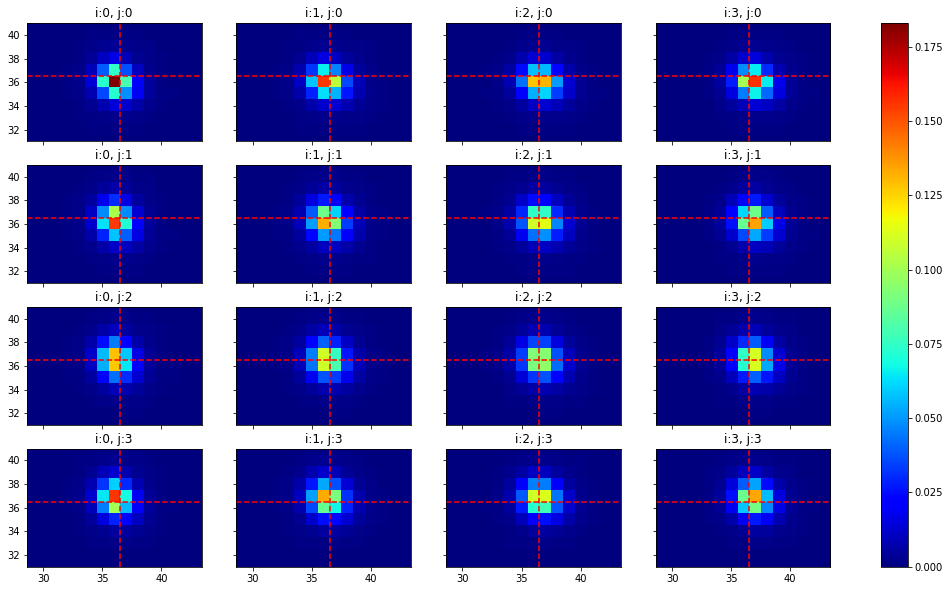

In [43]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(18, 10), sharex=True, sharey=True)
n1 = mpl.colors.Normalize()
n2 = mpl.colors.LogNorm()
for i in range(4):
    for j in range(4):
        plt.subplot(axes[j,i])
        plt.imshow(psf_c[j,i], norm=n1, cmap='jet')
        axes[j,i].axvline(x=73/2, color='r', ls='--')
        axes[j,i].axhline(y=73/2, color='r', ls='--')
        axes[j,i].set_title('i:{0:d}, j:{1:d}'.format(i,j))
axes[0,0].set_xlim([31, 41])
axes[0,0].set_ylim([31, 41])
plt.colorbar(ax=axes)

In [53]:
psf_me = make_tile(psf_c[0,0], shifts=[0., 0.25, 0.5, 0.75], norm=True)

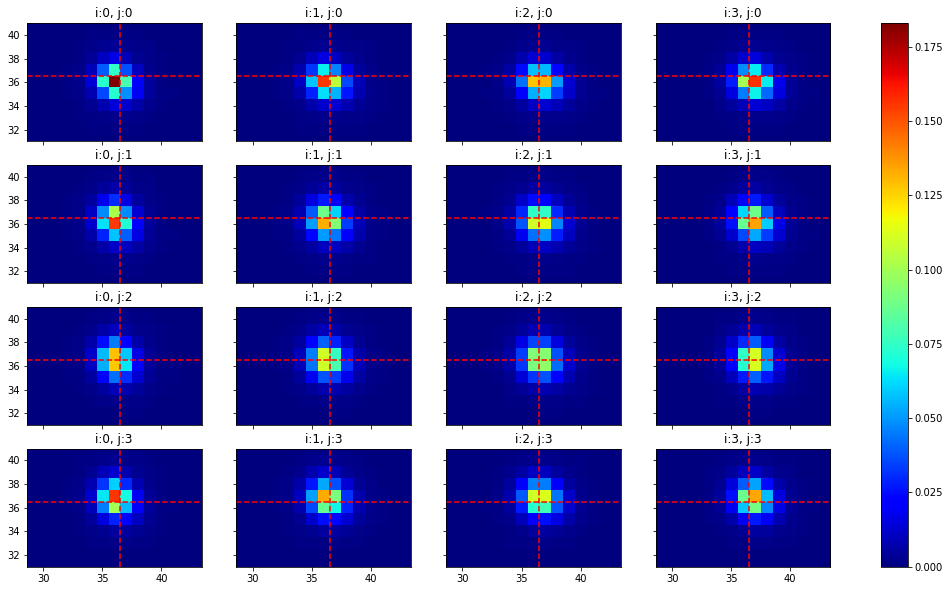

In [45]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(18, 10), sharex=True, sharey=True)
n1 = mpl.colors.Normalize()
n2 = mpl.colors.LogNorm()
for i in range(4):
    for j in range(4):
        plt.subplot(axes[j,i])
        plt.imshow(psf_me[j,i], norm=n1, cmap='jet')
        axes[j,i].axvline(x=73/2, color='r', ls='--')
        axes[j,i].axhline(y=73/2, color='r', ls='--')
        axes[j,i].set_title('i:{0:d}, j:{1:d}'.format(i,j))
axes[0,0].set_xlim([31, 41])
axes[0,0].set_ylim([31, 41])
plt.colorbar(ax=axes)

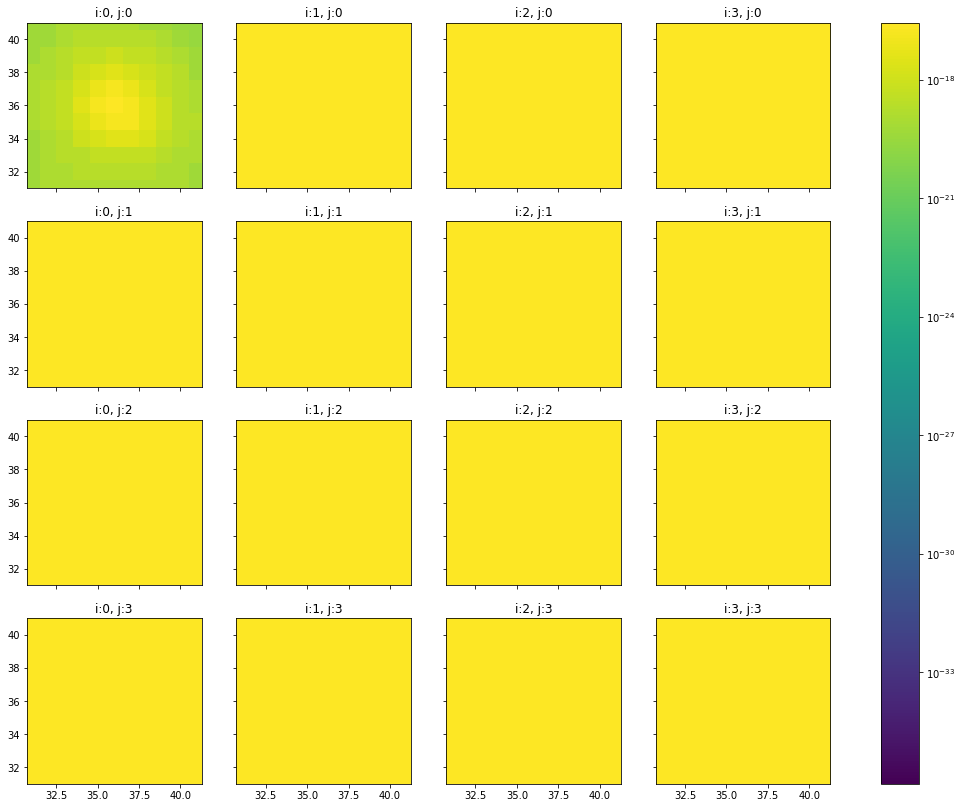

In [46]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(18, 14), sharex=True, sharey=True)
n1 = mpl.colors.Normalize()
n2 = mpl.colors.LogNorm()
for i in range(4):
    for j in range(4):
        plt.subplot(axes[j,i])
        plt.imshow(np.abs(psf_me[j,i] - psf_c[j,i]), norm=n2, cmap='viridis')
#         axes[j,i].axvline(x=73/2, color='r', ls='--')
#         axes[j,i].axhline(y=73/2, color='r', ls='--')
        axes[j,i].set_title('i:{0:d}, j:{1:d}'.format(i,j))
axes[0,0].set_xlim([31, 41])
axes[0,0].set_ylim([31, 41])
plt.colorbar(ax=axes)

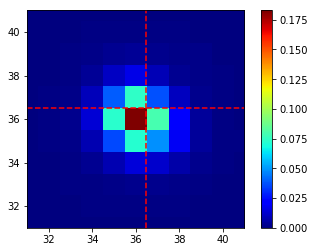

In [47]:
plt.imshow(psf, norm=n1, cmap='jet')
plt.xlim([31, 41]), plt.ylim([31, 41])
plt.axvline(x=73/2, color='r', ls='--')
plt.axhline(y=73/2, color='r', ls='--')
plt.colorbar()

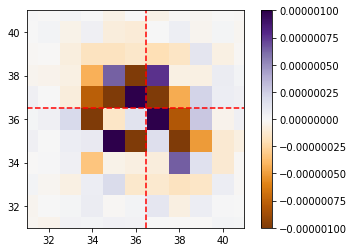

In [52]:
plt.imshow(psf_c[0,0]-psf, norm=mpl.colors.Normalize(vmin=-1e-6, vmax=1e-6), cmap='PuOr')
plt.xlim([31, 41]), plt.ylim([31, 41])
plt.axvline(x=73/2, color='r', ls='--')
plt.axhline(y=73/2, color='r', ls='--')
plt.colorbar()

In [134]:
np.max(np.abs(psf_c[3,0] - psf))

8.2334414150814217e-06

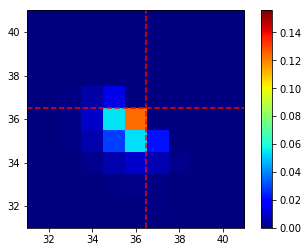

In [107]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
plt.subplot(axes[0])
plt.imshow(psf, norm=n1, cmap='jet')
plt.xlim([31, 41]), plt.ylim([31, 41])

plt.subplot(axes[1])
plt.imshow(psf_c[0,3], norm=n1, cmap='jet')
plt.axvline(x=73/2, color='r', ls='--')
plt.axhline(y=73/2, color='r', ls='--')

plt.colorbar()

In [24]:
def subpixel_shift(image, dx, dy):
    assert(np.abs(dx)<= 1.)
    assert(np.abs(dy)<= 1.)
    #roll the image by -1, 0, +1 in x and y
    rolls = np.zeros((3, 3, image.shape[0], image.shape[1]))
    for i, x in enumerate([-1, 0, 1]):
        for j, y in enumerate([-1, 0, 1]):
            rolls[j,i] = np.roll(np.roll(image, x, axis=1), y, axis=0)
    #make the coefficients for each corresponding rolled image
    coeffs = np.ones((3, 3))
    if np.isclose(dx, 0.):
        coeffs[:, 0] = coeffs[:, 2] = 0.
    elif dx < 0.:
        coeffs[:, 2] = 0.
        coeffs[:, 0] *= -dx
        coeffs[:, 1] *= 1 + dx
    else: 
        coeffs[:, 0] = 0.
        coeffs[:, 2] = dx
        coeffs[:, 1] *= 1 - dx
    if np.isclose(dy, 0.):
        coeffs[0, :] = coeffs[2, :] = 0.
    elif dy < 0.:
        coeffs[2, :] = 0.
        coeffs[0, :] *= -dy
        coeffs[1, :] *= 1 + dy
    else:
        coeffs[0, :] = 0.
        coeffs[2, :] *= dy
        coeffs[1, :] *= 1 - dy
    assert(np.isclose(np.sum(coeffs), 1.))
    result = np.zeros((image.shape[0], image.shape[0]))
    for i in range(3):
        for j in range(3):
            result += coeffs[i,j] * rolls[i,j]
    return result

In [25]:
def make_tile(image, shifts=[-.5, -.25, .25, .5], norm=False):
    tiles = np.zeros((len(shifts), len(shifts), image.shape[0], image.shape[1]))
    for i, dx in enumerate(shifts):
        for j, dy in enumerate(shifts):
            tiles[j,i] = subpixel_shift(image, dx, dy) 
            if norm:
                tiles[j,i] /= np.sum(tiles[j,i])
    return tiles

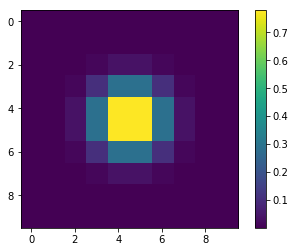

In [23]:
D = 10
w = 1.
psf = np.outer(gaussian(D, w), gaussian(D, w))
plt.imshow(psf)
plt.colorbar()

In [24]:
tiled_psf = make_tile(psf)

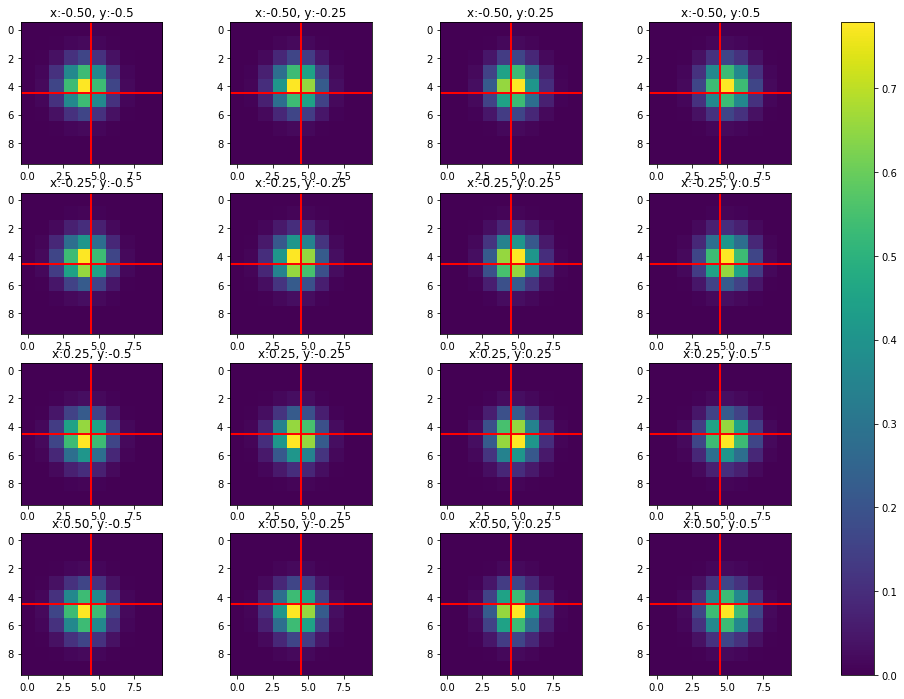

In [25]:
shifts = [-.5, -.25, .25, .5]
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(18, 12))
norm = mpl.colors.Normalize(vmin=0.)
for i in range(4):
    for j in range(4):
        plt.subplot(axes[j,i])
        plt.imshow(tiled_psf[j,i], cmap='viridis', norm=norm)
        axes[j,i].set_title('x:{0:.2f}, y:{1:.25}'.format(shifts[j], shifts[i]))
        axes[j,i].axvline(x=(D-1)/2., color='r', ls='-', lw=2)
        axes[j,i].axhline(y=(D-1)/2., color='r', ls='-', lw=2)
plt.colorbar(ax=axes)